In [1]:
import os
import io
from time import time
from datetime import datetime
import itertools
os.environ["CUDA_VISIBLE_DEVICES"]="-1" #set to -1 to disable gpu (on fresh kernel)

In [2]:
import tensorflow as tf
import keras

Using TensorFlow backend.


In [3]:
keras.backend.tensorflow_backend._get_available_gpus()
# tf.test.is_gpu_available()

[]

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
os.chdir(r"../immediate_results/")

In [6]:
df = pd.read_csv(r"cleandf_40days_930_to_1830_lin_interpolated.csv")

In [7]:
df[:10]

,CAMERA_ID,TIMESTAMP,GEO_LON,GEO_LAT,DENSITY_VALUE
0,4,2010-10-11 09:30:00,-0.227278,51.491661,53547.356500
1,4,2010-10-11 10:00:00,-0.227278,51.491661,46199.700875
2,4,2010-10-11 10:30:00,-0.227278,51.491661,39602.705900
3,4,2010-10-11 11:00:00,-0.227278,51.491661,27179.430333
4,4,2010-10-11 11:30:00,-0.227278,51.491661,23527.222300
5,4,2010-10-11 12:00:00,-0.227278,51.491661,19940.461500
6,4,2010-10-11 12:30:00,-0.227278,51.491661,20405.220000
7,4,2010-10-11 13:00:00,-0.227278,51.491661,21775.247000
8,4,2010-10-11 13:30:00,-0.227278,51.491661,18727.309900
9,4,2010-10-11 14:00:00,-0.227278,51.491661,17784.156700


In [8]:
# df.DENSITY_VALUE = np.log(df.DENSITY_VALUE)
df.DENSITY_VALUE -= df.DENSITY_VALUE.min()
df.DENSITY_VALUE /= df.DENSITY_VALUE.max()
df = df.pivot(index="TIMESTAMP",columns="CAMERA_ID",values="DENSITY_VALUE")
L = int(0.75 * len(df))

In [9]:
from keras import Sequential
from keras.layers import Dense, Activation, LSTM
from keras.optimizers import Adam, RMSprop
from keras import regularizers

from keras.layers import Input, Concatenate, Reshape, Lambda, Dropout
from keras.models import Model

from keras.callbacks import TensorBoard

import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model

In [10]:
TIMESTEPS = 19 * 7
CAMERA_FEATURES = 58
BATCH_SIZE = 1
LSTM_UNITS = 200
DENSE_UNITS = CAMERA_FEATURES

LSTM_DROPOUT = 0.25
DENSE_DROPOUT = 0.2

LSTM_L2_REG = 0.01
DENSE_L2_REG = 0.01

DENSE_ACT = "sigmoid"

In [11]:
def get_prepare_data(df, TIMESTEPS):
    
    def prepare_data(mode="train"):
        
        if mode == "train":
            while True:
                for i in range(0, L-TIMESTEPS):
                    yield np.reshape(df.iloc[i:i+TIMESTEPS,:].values,(1,TIMESTEPS,CAMERA_FEATURES) ), \
                          np.reshape(df.iloc[i+TIMESTEPS,:].values,(1,CAMERA_FEATURES) )
        elif mode == "eval":
            while True:
                for i in range(L-TIMESTEPS, len(df) - TIMESTEPS):
                    yield np.reshape(df.iloc[i:i+TIMESTEPS,:].values, (1,TIMESTEPS,CAMERA_FEATURES)), \
                          np.reshape(df.iloc[i+TIMESTEPS,:].values, (1,CAMERA_FEATURES) )
        elif mode == "predict":
            while True:
                for i in range(L-TIMESTEPS, len(df) - TIMESTEPS):
                    yield np.reshape(df.iloc[i:i+TIMESTEPS,:].values, (1,TIMESTEPS,CAMERA_FEATURES))
    
    return prepare_data

In [12]:
def plot_i(i,y,predictions):
    plt.figure()
    plt.plot([t[i] for t in y])
    plt.plot([t[i] for t in predictions])
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    image_string = buf.getvalue()
    buf.close()
    plt.close()
    return tf.Summary.Image(encoded_image_string = image_string)

In [13]:
def plot_pred_and_actual(model, eval_generator, i):
    one_test = itertools.islice(eval_generator, len(df) - L)
    a = list(one_test)
    X, y = zip(*a)
    y = np.array(y).reshape((len(df) - L, CAMERA_FEATURES)) #original y was (df-l,1,cam_feat)
    X = np.array(X).reshape((len(df) - L, -1, CAMERA_FEATURES))
    predictions = model.predict(X,batch_size=1)
    return plot_i(i,y,predictions)

In [14]:
class TrainValTensorBoard(TensorBoard):
    def __init__(self, generator, log_dir='./logs', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        os.mkdir(log_dir)
        self.generator = generator
        
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')
        


    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        
        if not self.model:
            print("Model not found in custom tensorboard callback.")
            self.val_writer.close()
            return
        
        img = plot_pred_and_actual(self.model, self.generator, 10) #10 is arbitrary (10th camera)
        summary_op = tf.Summary(value=[tf.Summary.Value(tag="prediction_vs_actual", image=img)])
        
        self.val_writer.add_summary(summary_op)
        self.val_writer.close()

In [15]:
def get_model(params):
    matrix_in = Input(batch_shape=(1,params["timesteps"],CAMERA_FEATURES),)
    denses_list = []
    for i in range(params["timesteps"]):
        slc = Lambda(lambda x: x[:,i,:])(matrix_in)
        drp = Dropout(rate=params["dense_dropout"],) (slc)
        dns = Dense(params["dense_units"], activation=params["dense_activation"]) (drp)
        rshp = Reshape( target_shape= (1,params["dense_units"]) ) (dns)   
        denses_list.append( rshp )

    concat = Concatenate(axis=1)(denses_list)
#     print(concat.shape)
    if "stack_lstm" in params and params["stack_lstm"] == True:
        lstm_tmp = LSTM( params["lstm_units"],
                         batch_input_shape=(1,params["timesteps"],params["dense_units"]), 
                         stateful=True,
#                          dropout=params["lstm_dropout"], 
                         activity_regularizer=regularizers.l2(l=params["lstm_l2reg"]),
                         return_sequences=True
                        ) (concat)
        
        lstm_out = LSTM(params["lstm_units"]) (lstm_tmp)
        
    else:
        lstm_out = LSTM( params["lstm_units"],
                         batch_input_shape=(1,params["timesteps"],params["dense_units"]), 
                         stateful=True,
                         dropout=params["lstm_dropout"], 
                         activity_regularizer=regularizers.l2(l=params["lstm_l2reg"])
                       ) (concat)
        
        
    out = Dense(params["dense_units"], activation= params["dense_activation"],
            activity_regularizer=regularizers.l2(l=params["dense_l2reg"])
           ) (lstm_out)
    out2 = Dropout(rate = params["dense_dropout"]) (out)
    out3 = Dense(CAMERA_FEATURES, activation=params["dense_activation"],
                 activity_regularizer=regularizers.l2(l=params["dense_l2reg"])
                ) (out2)

    return Model(inputs = matrix_in, outputs=out3)

In [15]:
from keras.layers import TimeDistributed, Bidirectional

In [16]:
def get_lstm_layers(params):
    """returns keras tensor output of a block of stateful lstms (potentially stacked)."""
    n = params["stack_lstm_count"]

    layers = []
    
    lstm1 = LSTM( params["lstm1_units"],
                     batch_input_shape=(1,params["timesteps"],params["dense_units"]), 
                     stateful=True,
                     return_sequences= True if n > 1 else False,
                     dropout=params["lstm1_dropout"],
                     recurrent_dropout=params["lstm1_recurrent_dropout"],
                     activity_regularizer=regularizers.l2(l=params["lstm1_l2reg"]),
                )
                 
    if "bidirectional_lstms" in params and params["bidirectional_lstms"] == True:
        lstm1 = Bidirectional(lstm1) #default mode is concat

    layers.append(lstm1)
                 
    if n == 1:
        return layers
        
    lstm2 = LSTM(params["lstm2_units"],
                     stateful=True,
                     return_sequences = True if n > 2 else False,
                     dropout=params["lstm2_dropout"],
                     recurrent_dropout=params["lstm2_recurrent_dropout"],
                     activity_regularizer=regularizers.l2(l=params["lstm2_l2reg"]),
                    )
                 
    if "bidirectional_lstms" in params and params["bidirectional_lstms"] == True:
        lstm2 = Bidirectional(lstm2) #default mode is concat  
    
    layers.append(lstm2)
                 
    if n == 2:
        return layers
                
    
    lstm3 = LSTM(params["lstm3_units"],
                stateful=True,
                return_sequences=False,
                dropout=params["lstm3_dropout"],
                recurrent_dropout=params["lstm3_recurrent_dropout"],
                activity_regularizer=regularizers.l2(l=params["lstm3_l2reg"]),
               )
                 
    if "bidirectional_lstms" in params and params["bidirectional_lstms"] == True:
        lstm3 = Bidirectional(lstm3) #default mode is concat  
                 
    layers.append(lstm3)
                 
    return layers

In [20]:
def get_model_timedist(params):
    matrix_in = Input(batch_shape=(1,params["timesteps"],CAMERA_FEATURES),)
    
    dns = TimeDistributed(Dense(params["dense_units"])) (matrix_in)
    concat = TimeDistributed(Dropout(rate=params["dense_dropout"])) (dns)
    
    lstm_layers = get_lstm_layers(params)
    
    lstm_out = concat
    for lstm in lstm_layers:
        lstm_out = lstm(lstm_out)
        
    out = Dense(params["dense_units"], activation= params["dense_activation"],
            activity_regularizer=regularizers.l2(l=params["dense_l2reg"])
           ) (lstm_out)
    out2 = Dropout(rate = params["dense_dropout"]) (out)
    out3 = Dense(CAMERA_FEATURES, activation=params["dense_activation"],
                 activity_regularizer=regularizers.l2(l=params["dense_l2reg"])
                ) (out2)

    return Model(inputs = matrix_in, outputs=out3)

In [21]:
def exp_loss(yTrue,yPred):
    return K.mean(K.exp(K.square(yTrue - yPred,)))

In [ ]:
#Trial1
paramss = []
# paramss.append({"timesteps" : 19, "lstm_units" : 20, "dense_units" : 58, "lstm_dropout" : 0.2, "dense_dropout" : 0.25,
#                "lstm_l2reg" : 0.01, "dense_l2reg" : 0.01, "dense_activation" : "sigmoid"})
# paramss.append({"timesteps" : 19*2, "lstm_units" : 20, "dense_units" : 58, "lstm_dropout" : 0.2, "dense_dropout" : 0.25,
#                "lstm_l2reg" : 0.01, "dense_l2reg" : 0.01, "dense_activation" : "sigmoid"})
# paramss.append({"timesteps" : 19*7, "lstm_units" : 20, "dense_units" : 58, "lstm_dropout" : 0.2, "dense_dropout" : 0.25,
#                "lstm_l2reg" : 0.01, "dense_l2reg" : 0.01, "dense_activation" : "sigmoid"})
# paramss.append({"timesteps" : 19*14, "lstm_units" : 20, "dense_units" : 58, "lstm_dropout" : 0.2, "dense_dropout" : 0.25,
#                "lstm_l2reg" : 0.01, "dense_l2reg" : 0.01, "dense_activation" : "sigmoid"})
# paramss.append({"timesteps" : 19*21, "lstm_units" : 20, "dense_units" : 58, "lstm_dropout" : 0.2, "dense_dropout" : 0.25,
#                "lstm_l2reg" : 0.01, "dense_l2reg" : 0.01, "dense_activation" : "sigmoid"})


# paramss.append({"desc" : "40units_28days", "timesteps" : 19*28, "lstm_units" : 40, "dense_units" : 58, "lstm_dropout" : 0.2, "dense_dropout" : 0.25,
#                "lstm_l2reg" : 0.01, "dense_l2reg" : 0.01, "dense_activation" : "sigmoid"})

# paramss.append({"desc" : "testing_lstm_size", "timesteps" : 19*21, "lstm_units" : 40, "dense_units" : 58, "lstm_dropout" : 0.2, "dense_dropout" : 0.25,
#                "lstm_l2reg" : 0.01, "dense_l2reg" : 0.01, "dense_activation" : "sigmoid"})
# paramss.append({"desc" : "testing_lstm_size", "timesteps" : 19*21, "lstm_units" : 80, "dense_units" : 58, "lstm_dropout" : 0.2, "dense_dropout" : 0.25,
#                "lstm_l2reg" : 0.01, "dense_l2reg" : 0.01, "dense_activation" : "sigmoid"})
# paramss.append({"desc" : "testing_lstm_size", "timesteps" : 19*21, "lstm_units" : 160, "dense_units" : 58, "lstm_dropout" : 0.2, "dense_dropout" : 0.25,
#                "lstm_l2reg" : 0.01, "dense_l2reg" : 0.01, "dense_activation" : "sigmoid"})
# paramss.append({"desc" : "testing_lstm_size", "timesteps" : 19*21, "lstm_units" : 320, "dense_units" : 58, "lstm_dropout" : 0.2, "dense_dropout" : 0.25,
#                "lstm_l2reg" : 0.01, "dense_l2reg" : 0.01, "dense_activation" : "sigmoid"})

# paramss.append({"desc" : "testing_dense_size", "timesteps" : 19*21, "lstm_units" : 80, "dense_units" : 58*2, "lstm_dropout" : 0.2, "dense_dropout" : 0.25,
#                "lstm_l2reg" : 0.01, "dense_l2reg" : 0.01, "dense_activation" : "sigmoid"})
# paramss.append({"desc" : "testing_dense_size", "timesteps" : 19*21, "lstm_units" : 80, "dense_units" : 58*3, "lstm_dropout" : 0.2, "dense_dropout" : 0.25,
#                "lstm_l2reg" : 0.01, "dense_l2reg" : 0.01, "dense_activation" : "sigmoid"})

# paramss.append({"desc" : "testing_relu", "timesteps" : 19*21, "lstm_units" : 80, "dense_units" : 58, "lstm_dropout" : 0.2, "dense_dropout" : 0.25,
#                "lstm_l2reg" : 0.01, "dense_l2reg" : 0.01, "dense_activation" : "relu"})

# paramss.append({"desc" : "testing_lstm_dropout", "timesteps" : 19*21, "lstm_units" : 80, "dense_units" : 58, "lstm_dropout" : 0.1, "dense_dropout" : 0.25,
#                "lstm_l2reg" : 0.01, "dense_l2reg" : 0.01, "dense_activation" : "sigmoid"})
# paramss.append({"desc" : "testing_lstm_dropout", "timesteps" : 19*21, "lstm_units" : 80, "dense_units" : 58, "lstm_dropout" : 0.3, "dense_dropout" : 0.25,
#                "lstm_l2reg" : 0.01, "dense_l2reg" : 0.01, "dense_activation" : "sigmoid"})
# paramss.append({"desc" : "testing_lstm_dropout", "timesteps" : 19*21, "lstm_units" : 80, "dense_units" : 58, "lstm_dropout" : 0.4, "dense_dropout" : 0.25,
#                "lstm_l2reg" : 0.01, "dense_l2reg" : 0.01, "dense_activation" : "sigmoid"})

# paramss.append({"desc" : "testing_dense_dropout", "timesteps" : 19*21, "lstm_units" : 80, "dense_units" : 58, "lstm_dropout" : 0.1, "dense_dropout" : 0.1,
#                "lstm_l2reg" : 0.01, "dense_l2reg" : 0.01, "dense_activation" : "sigmoid"})
# paramss.append({"desc" : "testing_dense_dropout", "timesteps" : 19*21, "lstm_units" : 80, "dense_units" : 58, "lstm_dropout" : 0.1, "dense_dropout" : 0.2,
#                "lstm_l2reg" : 0.01, "dense_l2reg" : 0.01, "dense_activation" : "sigmoid"})
# paramss.append({"desc" : "testing_dense_dropout", "timesteps" : 19*21, "lstm_units" : 80, "dense_units" : 58, "lstm_dropout" : 0.1, "dense_dropout" : 0.3,
#                "lstm_l2reg" : 0.01, "dense_l2reg" : 0.01, "dense_activation" : "sigmoid"})
# paramss.append({"desc" : "testing_dense_dropout", "timesteps" : 19*21, "lstm_units" : 80, "dense_units" : 58, "lstm_dropout" : 0.1, "dense_dropout" : 0.4,
#                "lstm_l2reg" : 0.01, "dense_l2reg" : 0.01, "dense_activation" : "sigmoid"})

# paramss.append({"desc" : "testing_lstm_reg",  "timesteps" : 19*21, "lstm_units" : 80, "dense_units" : 58, "lstm_dropout" : 0.2, "dense_dropout" : 0.25,
#                "lstm_l2reg" : 0.005, "dense_l2reg" : 0.01, "dense_activation" : "sigmoid"})
# paramss.append({"desc" : "testing_lstm_reg",  "timesteps" : 19*21, "lstm_units" : 80, "dense_units" : 58, "lstm_dropout" : 0.2, "dense_dropout" : 0.25,
#                "lstm_l2reg" : 0.05, "dense_l2reg" : 0.01, "dense_activation" : "sigmoid"})

# paramss.append({"desc" : "testing_dense_reg",  "timesteps" : 19*21, "lstm_units" : 80, "dense_units" : 58, "lstm_dropout" : 0.2, "dense_dropout" : 0.25,
#                "lstm_l2reg" : 0.01, "dense_l2reg" : 0.005, "dense_activation" : "sigmoid"})
# paramss.append({"desc" : "testing_dense_reg", "timesteps" : 19*21, "lstm_units" : 80, "dense_units" : 58, "lstm_dropout" : 0.2, "dense_dropout" : 0.25,
#                "lstm_l2reg" : 0.01, "dense_l2reg" : 0.05, "dense_activation" : "sigmoid"})

# paramss.append({"desc" : "timedist_withdropout", "timesteps" : 19*21, "lstm_units" : 80, "dense_units" : 58*3, "lstm_dropout" : 0.4, "dense_dropout" : 0.4,
#                "lstm_l2reg" : 0.05, "dense_l2reg" : 0.005, "dense_activation" : "sigmoid"})

# paramss.append({"desc" : "testing_stacked_lstm", "timesteps" : 19*21, "lstm_units" : 80, "dense_units" : 58*3, "lstm_dropout" : 0.4, "dense_dropout" : 0.4,
#                "lstm_l2reg" : 0.05, "dense_l2reg" : 0.005, "dense_activation" : "sigmoid", "stack_lstm" : True})

# paramss.append({"desc" : "stacked_tryagain", "timesteps" : 19*21, "lstm_units" : 80, "dense_units" : 58*3, "lstm_dropout" : 0.4, "dense_dropout" : 0.4,
#                "lstm_l2reg" : 0.05, "dense_l2reg" : 0.005, "dense_activation" : "sigmoid", "stack_lstm" : True})

# paramss.append({"desc" : "stacked_dropouton2", "timesteps" : 19*21, "lstm_units" : 80, "dense_units" : 58*3, "lstm_dropout" : 0.4, "dense_dropout" : 0.4,
#                "lstm_l2reg" : 0.05, "dense_l2reg" : 0.005, "dense_activation" : "sigmoid", "stack_lstm" : True})

# paramss.append({"desc" : "stacked_dropoutandregon2", "timesteps" : 19*21, "lstm_units" : 80, "dense_units" : 58*3, "lstm_dropout" : 0.4, "dense_dropout" : 0.4,
#                "lstm_l2reg" : 0.05, "dense_l2reg" : 0.005, "dense_activation" : "sigmoid", "stack_lstm" : True})

# paramss.append({"desc" : "stacked_wrecurrentdouton2", "timesteps" : 19*21, "lstm_units" : 80, "dense_units" : 58*3, "lstm_dropout" : 0.4, "dense_dropout" : 0.4,
#                "lstm_l2reg" : 0.05, "dense_l2reg" : 0.005, "dense_activation" : "sigmoid", "stack_lstm" : True})

# paramss.append({"desc" : "stack2_plain_trying_refactoredcode", "stack_lstm_count" : 2, "timesteps" : 19*21, "lstm_units" : 80, "dense_units" : 58*3, "lstm_dropout" : 0.4, "dense_dropout" : 0.4,
#                "lstm_l2reg" : 0.05, "dense_l2reg" : 0.005, "dense_activation" : "sigmoid"})

paramss.append({"desc" : "stack2_plain_trying_refactoredcode", "stack_lstm_count" : 3, "timesteps" : 19*21, "lstm_units" : 80, "dense_units" : 58*3, "lstm_dropout" : 0.4, "dense_dropout" : 0.4,
               "lstm_l2reg" : 0.05, "dense_l2reg" : 0.005, "dense_activation" : "sigmoid"})


In [ ]:
#Trial2: after refactor
paramss = []
paramss.append({"desc" : "testing_bidirectional", "timesteps" : 19*21, "loss" : exp_loss,
                "stack_lstm_count" : 2, "bidirectional_lstms" : True,
                "lstm1_units" : 80, "lstm1_dropout" : 0, "lstm1_recurrent_dropout" : 0, "lstm1_l2reg" : 0.,
                "lstm2_units" : 80, "lstm2_dropout" : 0.4, "lstm2_recurrent_dropout" : 0, "lstm2_l2reg" : 0.05,
                "dense_units" : 58*3, "dense_dropout" : 0.4, "dense_l2reg" : 0.001, "dense_activation" : "sigmoid"})

paramss.append({"desc" : "mimic_v1_stacked_after_refactor", "timesteps" : 19*21, "loss" : exp_loss,
                "stack_lstm_count" : 2, 
                "lstm1_units" : 80, "lstm1_dropout" : 0, "lstm1_recurrent_dropout" : 0, "lstm1_l2reg" : 0.,
                "lstm2_units" : 80, "lstm2_dropout" : 0.4, "lstm2_recurrent_dropout" : 0, "lstm2_l2reg" : 0.05,
                "dense_units" : 58*3, "dense_dropout" : 0.4, "dense_l2reg" : 0.001, "dense_activation" : "sigmoid"})

paramss.append({"desc" : "mimic_v1_stacked_with_mse_loss", "timesteps" : 19*21, "loss" : "mse",
                "stack_lstm_count" : 2, 
                "lstm1_units" : 80, "lstm1_dropout" : 0, "lstm1_recurrent_dropout" : 0, "lstm1_l2reg" : 0.,
                "lstm2_units" : 80, "lstm2_dropout" : 0.4, "lstm2_recurrent_dropout" : 0, "lstm2_l2reg" : 0.05,
                "dense_units" : 58*3, "dense_dropout" : 0.4, "dense_l2reg" : 0.001, "dense_activation" : "sigmoid"})

In [22]:
#Trial3

paramss = []
paramss.append({"desc" : "testing_stack_nornnreg", "timesteps" : 19*21, "loss" : exp_loss,
                "stack_lstm_count" : 2, "bidirectional_lstms" : False,
                "lstm1_units" : 80, "lstm1_dropout" : 0, "lstm1_recurrent_dropout" : 0., "lstm1_l2reg" : 0.,
                "lstm2_units" : 80, "lstm2_dropout" : 0, "lstm2_recurrent_dropout" : 0., "lstm2_l2reg" : 0.,
                "dense_units" : 58*3, "dense_dropout" : 0.4, "dense_l2reg" : 0.001, "dense_activation" : "sigmoid"})

paramss.append({"desc" : "testing_stack3_nornnreg", "timesteps" : 19*21, "loss" : exp_loss,
                "stack_lstm_count" : 3, "bidirectional_lstms" : False,
                "lstm1_units" : 80, "lstm1_dropout" : 0, "lstm1_recurrent_dropout" : 0., "lstm1_l2reg" : 0.,
                "lstm2_units" : 80, "lstm2_dropout" : 0, "lstm2_recurrent_dropout" : 0., "lstm2_l2reg" : 0.,
                "lstm3_units" : 80, "lstm3_dropout" : 0, "lstm3_recurrent_dropout" : 0., "lstm3_l2reg" : 0.,
                "dense_units" : 58*3, "dense_dropout" : 0.4, "dense_l2reg" : 0.001, "dense_activation" : "sigmoid"})

paramss.append({"desc" : "testing_stack2_recdoutboth", "timesteps" : 19*21, "loss" : exp_loss,
                "stack_lstm_count" : 2, "bidirectional_lstms" : False,
                "lstm1_units" : 80, "lstm1_dropout" : 0, "lstm1_recurrent_dropout" : 0.4, "lstm1_l2reg" : 0.,
                "lstm2_units" : 80, "lstm2_dropout" : 0, "lstm2_recurrent_dropout" : 0.4, "lstm2_l2reg" : 0.,
                "dense_units" : 58*3, "dense_dropout" : 0.4, "dense_l2reg" : 0.001, "dense_activation" : "sigmoid"})

paramss.append({"desc" : "testing_stack2_recdouton2", "timesteps" : 19*21, "loss" : exp_loss,
                "stack_lstm_count" : 2, "bidirectional_lstms" : False,
                "lstm1_units" : 80, "lstm1_dropout" : 0, "lstm1_recurrent_dropout" : 0., "lstm1_l2reg" : 0.,
                "lstm2_units" : 80, "lstm2_dropout" : 0, "lstm2_recurrent_dropout" : 0.4, "lstm2_l2reg" : 0.,
                "dense_units" : 58*3, "dense_dropout" : 0.4, "dense_l2reg" : 0.001, "dense_activation" : "sigmoid"})


In [23]:

CURRENT_TIME = datetime.now().strftime("%Y-%m-%d %H-%M")

for params in paramss:
    
    model = get_model_timedist(params)

    model.compile(optimizer=Adam(lr=0.001,clipnorm=1.), loss=params["loss"], metrics=["mse"])

    print(model.summary())
#     LOGDIR = "logs/TS[{}]LSTM[unit{},drate{},l2reg{}]D[unit{},drate{},l2reg{},{}][{}][{}]".format(
#                                              params["timesteps"],
#                                              params["lstm_units"], params["lstm_dropout"], params["lstm_l2reg"],
#                                              params["dense_units"], params["dense_dropout"], params["dense_l2reg"], params["dense_activation"],
#                                              params["desc"],
#                                              CURRENT_TIME )
    LOGDIR = "logs/{}[{}]".format(params["desc"], CURRENT_TIME )

    prepare_data = get_prepare_data(df, params["timesteps"])

    tensorboard = TrainValTensorBoard(generator=prepare_data(mode="eval"), log_dir= LOGDIR)
    #, write_grads=True, histogram_freq= 2, batch_size=1 )

    es = EarlyStopping(monitor="val_loss", patience=10, min_delta=0.001, restore_best_weights=True)

    #logging parameters to text file
    with open('params_log_lstm_for_london.txt', 'a') as f:
        print(params, file=f)
        
    history = model.fit_generator(prepare_data(mode="train"),
                                  epochs = 250,
                                  steps_per_epoch= L-params["timesteps"],
                                  validation_data = prepare_data(mode="eval"),
                                  validation_steps = len(df) - L, 
                                  callbacks=[tensorboard,es]
                                 )
    
    del model
    del history
    del prepare_data
    K.clear_session() #to hopefully prevent slow down after a few models..

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (1, 399, 58)              0         
_________________________________________________________________
time_distributed_1 (TimeDist (1, 399, 174)             10266     
_________________________________________________________________
time_distributed_2 (TimeDist (1, 399, 174)             0         
_________________________________________________________________
lstm_1 (LSTM)                (1, 399, 80)              81600     
_________________________________________________________________
lstm_2 (LSTM)                (1, 80)                   51520     
_________________________________________________________________
dense_2 (Dense)      

Epoch 1/250
437/437 [==============================] - 125s 286ms/step - loss: 1.0321 - mean_squared_error: 0.0188 - val_loss: 1.0300 - val_mean_squared_error: 0.0215
Epoch 2/250
437/437 [==============================] - 124s 283ms/step - loss: 1.0235 - mean_squared_error: 0.0156 - val_loss: 1.0291 - val_mean_squared_error: 0.0216
Epoch 3/250
437/437 [==============================] - 124s 284ms/step - loss: 1.0229 - mean_squared_error: 0.0159 - val_loss: 1.0291 - val_mean_squared_error: 0.0219
Epoch 4/250
437/437 [==============================] - 125s 285ms/step - loss: 1.0212 - mean_squared_error: 0.0146 - val_loss: 1.0279 - val_mean_squared_error: 0.0215
Epoch 5/250
437/437 [==============================] - 124s 284ms/step - loss: 1.0222 - mean_squared_error: 0.0158 - val_loss: 1.0297 - val_mean_squared_error: 0.0225
Epoch 6/250
437/437 [==============================] - 126s 287ms/step - loss: 1.0205 - mean_squared_error: 0.0143 - val_loss: 1.0276 - val_mean_squared_error: 0.021

Epoch 1/250
437/437 [==============================] - 105s 241ms/step - loss: 1.0319 - mean_squared_error: 0.0187 - val_loss: 1.0296 - val_mean_squared_error: 0.0213
Epoch 2/250
437/437 [==============================] - 111s 254ms/step - loss: 1.0231 - mean_squared_error: 0.0154 - val_loss: 1.0285 - val_mean_squared_error: 0.0211
Epoch 3/250
437/437 [==============================] - 112s 257ms/step - loss: 1.0220 - mean_squared_error: 0.0150 - val_loss: 1.0233 - val_mean_squared_error: 0.0164
Epoch 4/250
437/437 [==============================] - 107s 244ms/step - loss: 1.0176 - mean_squared_error: 0.0110 - val_loss: 1.0197 - val_mean_squared_error: 0.0133
Epoch 5/250
437/437 [==============================] - 101s 231ms/step - loss: 1.0176 - mean_squared_error: 0.0113 - val_loss: 1.0190 - val_mean_squared_error: 0.0127
Epoch 6/250
437/437 [==============================] - 106s 243ms/step - loss: 1.0162 - mean_squared_error: 0.0101 - val_loss: 1.0184 - val_mean_squared_error: 0.012

### Notes

1- ts399, lstm units 320 took 20 minute per epoch! (it might have been code artifact or my computer behavior though)

2- lstm size seems not to matter (40, 80, 160) doesn't change result much.

3- dense size seems to matter (better peaks) going from 116 to 174.

4- sigmoids seems better than relu (on all activations).

5- 399 seems better than 528 (28 day * 19 per day records I believe).

6- lstm 0.05 l2reg (higher one) seems better.

7- dense 0.005 l2reg (lower one) seems much better.

8- lstm dropout 0.4 seems better (highest tried).

9- dense dropout 0.3 or 0.4 (maybe 0.4).

10- stacking without regularization for lstms seems better.

11- recurrent dropout on lstm2 seemed to mess it up as well.

In [2]:
param_v1 = {"desc" : "testing_mix_v1", "timesteps" : 19*21, "lstm_units" : 80, "dense_units" : 58*3, "lstm_dropout" : 0.4, "dense_dropout" : 0.4,
               "lstm_l2reg" : 0.05, "dense_l2reg" : 0.005, "dense_activation" : "sigmoid"}

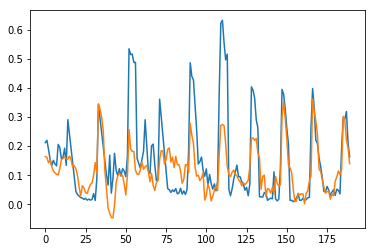

In [64]:
plot_pred_and_actual(model3,10)

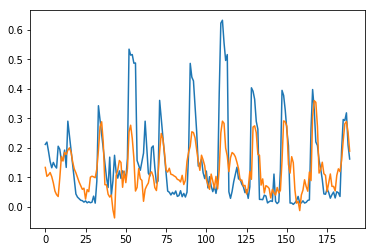

In [69]:
plot_pred_and_actual(model4,10)

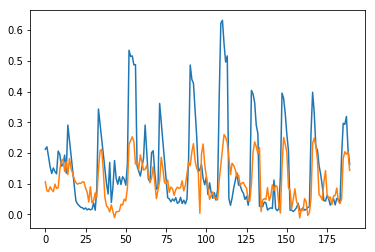

In [66]:
plot_pred_and_actual(model5,10)

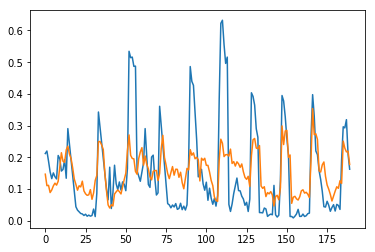

In [87]:
plot_pred_and_actual(model,10)

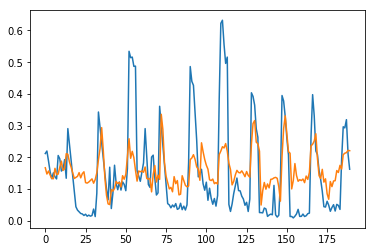

In [24]:
plot_pred_and_actual(model,10)

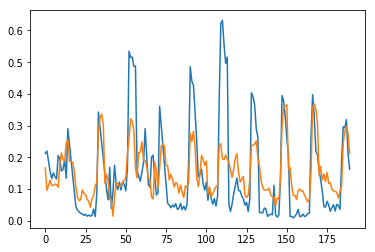

In [27]:
plot_pred_and_actual(model,10)

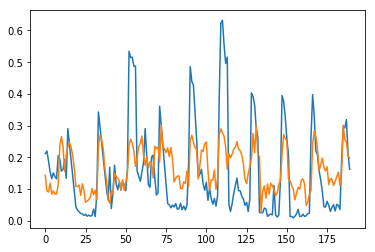

In [32]:
plot_pred_and_actual(model,10)

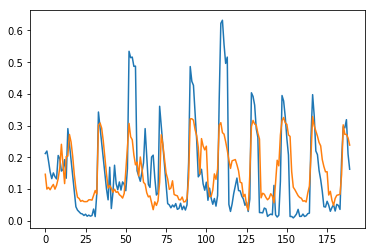

In [18]:
plot_pred_and_actual(model,10)

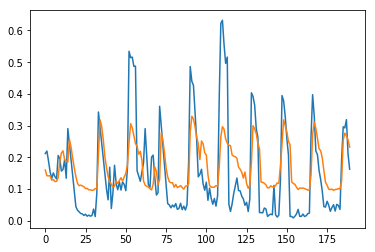

In [29]:
plot_pred_and_actual(model,10)

__With denses it became smoother :-? hmmm__

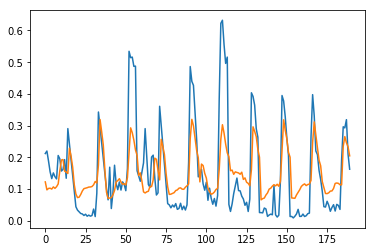

In [33]:
plot_pred_and_actual(model,10)